### Cloud Mask Project

Abstract of the project available in https://docs.google.com/document/d/1T-uMGFXgOIb0-DgFu4H25VU6gPrn4d5ybH_vMQYK2aI/edit

Questions:
- Maybe we should think of masking more than one single granule?
- Bagging between images, intead of rows of the final dataframes
- Re-think training-test-val based on dt
- Problems installing regreg
- Other weather data
- Do we want to treat Integer_Cloud_Mask as a binary variable, categorical, or quantitatively?
- Different analysis for strong and weak beam
- Normalization of data? When we make scalling, we do it once with training and we keep the parameters? Weird implementation
- Outliers
- Questions about Jonathan's model: what about the marginals?


To do:
- How to split between training and test?
- (Done) Find the way to login to Earthdata just once for all the VIIRS + ATL06 retrievals
- Add all the features from ALT06 we find interesting and re-order columns
- Add time efficiently to ATL06 data frames (problem with timestamps)
- (Done) check if the time window is correct (how to access date and time in ATL?)
- Raise a better error messege for the case of missing data
- (Done) Index in the ATL06 dataframes. There are a lot of repetitions
- (Done) Grid correction: do the vertices on VIIDS correspond to the center of the cell or to the real vertices of a cell? In that case, we need to shift the net.
(Answer: this is for MODIS)
- Change Ball Tree for something faster
- Which is a good spatial window for VIIRS? 1km? How to go from (delta_lat, delta_lon) to delta_meters?
- Should I be careful with the VIIRS images we use? Focus maybe on some moment of the year + some region (Antarctice y/o Greenland)
- Is there any way to access VIIRS metadata?
- Parallelize each VIIRS call
- Where to call each library and python script?

In [1]:
from icepyx import query as ipd
#from icepyx import icesat2data as ipd

from pathlib import Path
import h5py
import os
import numpy as np
import pandas as pd
import pyproj
import pickle
import random
from astropy.time import Time
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import *
from utils_atl06 import read_atl06_fromfile, atl06_2_df, read_atl06
from utils_viirs import associate, viirs_date

### VIIRS Asimilation

In [4]:
# Directory where the VIIRS data is located
path_data_VIIRS = 'data/VIIRS-fulltemporalextent'
# Directory where the ATL06 is located or should be downloaded 
path_data_ATL06 = 'data/new_ATL06/'
# Name of the pickle file where we download the dictonary data
dict_save = "dict_VIIRS_2_ATL06_dt20_full.pkl"

# Spatial Extent
spatial_extent = [-50, 68, -45, 73]
#spatial_extent = [float(x) for x in spatial_extent]   # remove this line once Issue 82 is solved 
# Window in hours to retrieve ICESat-2 data around VIIRS image
hr = 0.5
# Name of the column with the difference in minutes between ICESat-2 and VIIRS
cld_t_var = 'VIIRS_offset'
# Name of the variable with the cloud mask indicatos in VIIRS
V_variable = 'Integer_Cloud_Mask'
# Number of nearest neighbours to consider for the assimilation
k = 10
# Distance in kilometers above which ICESat-2 measuraments will be discarted in case that there is no spatial match with VIIRS
tolerance_spatial_dismatch = 1 
# Approximate radii of the Earth
radii = 6371

In [23]:
Vfiles = get_file_in_directory(path_data_VIIRS)

VIIRS_2_ATL06 = {}

for Vfile in Vfiles: 

    """
    Atmospheric product retrieval.
    
    This part should be return the same for all the external producs:
    
        - f_t: timestamp where the product was recorded
        - latS : 2-dimensional np.array with the latitudes
        - lonS : 2-dimensional np.array with the longitudes
        - extract : np.array with the label of the product
    
    """
    
    Vfile_name = Vfile.split("/")[-1]
    print("Name of VIIRS file:", Vfile_name)
    
    try:
    
        # Temportal properties
        f_ = h5py.File(Vfile)     
        f_t = viirs_date(Vfile)

        # Spatial properties
        latS = f_["geolocation_data"]["latitude"][:]
        lonS = f_["geolocation_data"]["longitude"][:]
        assert latS.shape == lonS.shape, "latS and lonS must have the same shape"

        # Label
        extract = f_['geophysical_data'][V_variable].value
        assert extract.shape == latS.shape, "Labels and latS must have the same shape"


        """
        Preprocesing of the atmospheric product 
        """

        # I change the coordinates to radians and I stack pairs of (latitude, longitede) 

        #S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
        S_rad = np.vstack([latS[:].ravel(), lonS[:].ravel()]).T
        S_rad *= np.pi / 180.


        """
        ATL06 Retrieval
        """

        # Temporal search window for 
        start = f_t - pd.DateOffset(hours=hr)
        end   = f_t + pd.DateOffset(hours=hr)

        start_date_str = start.strftime('%Y-%m-%d')
        end_date_str   = end.strftime('%Y-%m-%d')
        start_time_str = start.strftime('%H:%M:%S')
        end_time_str   = end.strftime('%H:%M:%S')

        
        
        date_range = [start_date_str, end_date_str]

        df = read_atl06(spatial_extent = spatial_extent,
                        date_range = date_range,
                        time_start = start_time_str,
                        time_end = end_time_str,
                        path = path_data_ATL06)

        
        if df.shape[0] == 0:
            print("The retrieved dataframes has no entries.")
            continue

        latF = df.lat.values 
        lonF = df.lon.values

        #F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
        F_rad = np.vstack([latF[:].ravel(), lonF[:].ravel()]).T
        F_rad *= np.pi / 180.

        """
        Assimilation
        """

        # Label Assimilation

        distances, indices = associate(S_rad, F_rad, k_nn=k)

        for i in range(indices.shape[1]):

            new_column = extract.ravel()[indices[:, i]]
            
            if i == 0:
                col_name = V_variable
            else:
                col_name = V_variable + "_k" + str(i + 1)
                
            df[ col_name ] = new_column
            df[ col_name + "_dist" ] = distances[:, i]


        # I filter ATL points outside the VIIRS Image
        df = df[ df[V_variable + "_dist"] < tolerance_spatial_dismatch / radii ]

        # Difference on time assimilation 
        df["delta_assim"] = abs( df.time - f_t ) / np.timedelta64(1,'m')         
        #df["delta_assim"] = abs( df.t_year - f_t ) / np.timedelta64(1,'m') 
        # I filter points outside the temporal window 
        df = df[ df["delta_assim"] < 60 * hr ]

        # Add name of VIIRS file to the column of the dataframes
        df['viirs_source'] = Vfile_name 

        
        VIIRS_2_ATL06[Vfile] = df

        a_file = open(dict_save, "wb")
        pickle.dump(VIIRS_2_ATL06, a_file)
        a_file.close()

    
    except:
        print("Error")

    
print("Process completed")

Name of VIIRS file: data/VIIRS-fulltemporalextent/CLDMSK_L2_VIIRS_SNPP.A2019032.1318.001.2019062071033.nc


<ipython-input-23-5da0cdae7c83>:24: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Vfile)
<ipython-input-23-5da0cdae7c83>:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  extract = f_['geophysical_data'][V_variable].value


Available Granules: ['ATL06_20190201130034_05360203_003_01.h5']
You already donwload all the requiered files
Error
Process completed


## Data Preparation 

In [5]:
#infile = open('dict_VIIRS_2_ATL06_dt20_full_incomplete.pkl','rb')
infile = open('dict_VIIRS_2_ATL06_dt20_full.pkl','rb')

dict_VIIRS2ATL = pickle.load(infile)
infile.close()

In [6]:
list_keys = list(dict_VIIRS2ATL.keys())
res = 0
for x in list_keys:
    
    #print(x)
    print(dict_VIIRS2ATL[x].shape)
    res += dict_VIIRS2ATL[x].shape[0]

(161978, 53)
(48007, 53)
(0, 53)
(125017, 53)
(153, 53)
(12275, 53)
(31807, 53)
(10654, 53)
(76774, 53)
(117651, 53)
(22397, 53)
(168597, 53)
(89692, 53)
(42803, 53)
(152898, 53)
(1507, 53)
(64321, 53)
(94294, 53)
(102557, 53)
(136029, 53)
(72046, 53)
(47860, 53)
(76978, 53)
(112573, 53)
(93975, 53)
(76305, 53)
(135984, 53)
(107185, 53)
(76564, 53)
(1163, 53)
(0, 53)
(66110, 53)
(67887, 53)
(138405, 53)
(94134, 53)
(105411, 53)
(2490, 53)
(21906, 53)
(137468, 53)
(0, 53)
(61178, 53)
(44406, 53)
(36648, 53)
(87955, 53)
(36297, 53)
(51219, 53)
(46974, 53)
(141606, 53)
(4017, 53)
(62386, 53)
(0, 53)
(111130, 53)
(42195, 53)
(3745, 53)
(21187, 53)
(155093, 53)
(74517, 53)
(60253, 53)
(138995, 53)
(166798, 53)
(15014, 53)
(38562, 53)
(68571, 53)
(83782, 53)
(45094, 53)
(149469, 53)
(161882, 53)
(418, 53)
(60856, 53)
(937, 53)
(41001, 53)
(122130, 53)
(61734, 53)
(24386, 53)
(0, 53)
(0, 53)
(17250, 53)
(13414, 53)
(26861, 53)
(29770, 53)
(150376, 53)
(97390, 53)
(151537, 53)
(168595, 53)
(79

In [7]:
len(list_keys)

112

I filter the VIIRS files that have at least a minimum of different ATL06 measuraments. The filters we consider for this first part include:

1. Since the Strong and Weak retrievals have different statistics, like different number of signal photons, we restric the analysis to pne single set of beams (namely, strong or weak). 
2. I will only consider retrievals with high confidence in the VIIRS flag, that is, Integer_Cloud_Mask = 0 or 3.
3. I restrict the analysis to rows for which the temporal dismatch is small 
4. Then, I filter VIIRS images for which I have enough ATLAS retrievals.
5. Removal of outliers (check)

For the VIIRS-ICESat2 retrievals that pass these filters, I restrict the analysis to a subsample of the rows. This is done because the unbalanced proportion of retrievals per VIIRS image.

In [8]:
dt = 8 # minutes
N_filt = 1000

viirs_filtered = []
dict_VIIRS2ATL_filtered = {}

for x in list_keys:
    
    df = dict_VIIRS2ATL[x]
    df = df[df.beam_strength == 'strong']
    df = df[df.Integer_Cloud_Mask.isin([0,3])]   
    df = df[df.delta_assim < dt]
    #print(df.shape)
    df = df[df.height < 10e30]
    df = df[df.slope_dx < 10e30]
    df = df[df.slope_dy < 10e30]
    df = df[df.snr < 10e30]
    #print(df.shape)
    
    if df.shape[0] >= N_filt:
        
        viirs_filtered.append(x)
        dict_VIIRS2ATL_filtered[x] = df.sample(n = N_filt)

In [9]:
len(viirs_filtered)

31

In [10]:
len(viirs_filtered) / len(list_keys) * 100

27.67857142857143

In [11]:
for x in dict_VIIRS2ATL_filtered.keys():
    print(dict_VIIRS2ATL_filtered[x].shape)

(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)
(1000, 53)


In [12]:
random.seed(6)
random.shuffle(viirs_filtered)

prop_train = 60
prop_val   = 20
prop_test  = 20

N0 = int( prop_train * len(viirs_filtered) / 100 )
N1 = int( (prop_train + prop_val) * len(viirs_filtered) / 100 )

viirs_train = viirs_filtered[:N0]
viirs_val   = viirs_filtered[N0:N1]
viirs_test  = viirs_filtered[N1:]

In [13]:
assert len(viirs_train) + len(viirs_val) + len(viirs_test) == len(viirs_filtered)
assert list(set(viirs_train) & set(viirs_val)) == []
assert list(set(viirs_train) & set(viirs_test)) == []
assert list(set(viirs_val) & set(viirs_test)) == []

In [14]:
df_train = merge_df_from_dict(dict_VIIRS2ATL_filtered, entries_to_merge=viirs_train, shuff=True)
df_val   = merge_df_from_dict(dict_VIIRS2ATL_filtered, entries_to_merge=viirs_val, shuff=True)
df_test  = merge_df_from_dict(dict_VIIRS2ATL_filtered, entries_to_merge=viirs_test, shuff=True)

In [15]:
df_train.columns

Index(['ground_track', 'time', 'segment_id', 'beam_strength', 'lat', 'lon',
       'height', 'slope_dx', 'slope_dy', 'snr', 'q_flag', 'h_rb',
       'height_sigma', 'snr_significance', 's_fg', 'n_fit_photons',
       'w_surface_window_final', 'n_fit_photons_ratio_w', 'blowing_snow_conf',
       'blowing_snow_h', 'blowing_snow_od', 'c_flg_asr', 'c_flg_atm', 'msw',
       'layer_flag', 'background', 'background_expected', 'q_flag_1',
       'q_flag_2', 'q_flag_3', 'q_flag_4', 'q_flag_5', 'Integer_Cloud_Mask',
       'Integer_Cloud_Mask_dist', 'Integer_Cloud_Mask_k2',
       'Integer_Cloud_Mask_k2_dist', 'Integer_Cloud_Mask_k3',
       'Integer_Cloud_Mask_k3_dist', 'Integer_Cloud_Mask_k4',
       'Integer_Cloud_Mask_k4_dist', 'Integer_Cloud_Mask_k5',
       'Integer_Cloud_Mask_k5_dist', 'Integer_Cloud_Mask_k6',
       'Integer_Cloud_Mask_k6_dist', 'Integer_Cloud_Mask_k7',
       'Integer_Cloud_Mask_k7_dist', 'Integer_Cloud_Mask_k8',
       'Integer_Cloud_Mask_k8_dist', 'Integer_Cloud_Mask

In [16]:
df_train['q_viirs'] = df_train.apply(lambda row: 1 if (row.Integer_Cloud_Mask < 2) else 0, axis = 1)
df_train['q_viirs_10'] = df_train.apply(lambda row: 1 if (row.Integer_Cloud_Mask_k10 < 2) else 0, axis = 1)

df_val['q_viirs'] = df_val.apply(lambda row: 1 if (row.Integer_Cloud_Mask < 2) else 0, axis = 1)
df_val['q_viirs_10'] = df_val.apply(lambda row: 1 if (row.Integer_Cloud_Mask_k10 < 2) else 0, axis = 1)

In [17]:
# Points to use in training
#N = 100000
N = 5000
# Variables I want to use
#col_names = ['h_rb', 'height_sigma', 'snr_significance','s_fg', 'n_fit_photons_ratio_w']
col_names = ['height','slope_dx', 'slope_dy', 'snr', 'h_rb', 'height_sigma', 'snr_significance','s_fg', 'n_fit_photons_ratio_w', 'c_flg_asr']
col_names = ['height','slope_dx', 'slope_dy', 'snr', 'h_rb', 'height_sigma', 'snr_significance','s_fg', 'n_fit_photons_ratio_w', 'c_flg_asr', 'lat', 'lon']

# restriction to strong beam
df_train_sample = df_train[df_train.beam_strength == 'strong'].sample(n=N)
df_val_sample = df_val[df_val.beam_strength == 'strong'].sample(n=N)

X_train = df_train_sample[col_names].to_numpy()
X_val   = df_val_sample[col_names].to_numpy()


Y_train = df_train_sample[['q_viirs']].to_numpy().reshape(-1)
Y_val   = df_val_sample[['q_viirs']].to_numpy().reshape(-1)

Y_train_fake = df_train_sample[['q_flag']].to_numpy().reshape(-1)

In [113]:
np.unique(df_train.c_flg_asr.values)

array([0, 1, 2, 3, 4, 5], dtype=int8)

In [114]:
np.max(df_train.snr.values)

46992.7

In [23]:
from sklearn import preprocessing

X_train_scaled = preprocessing.scale(X_train, axis=0)
X_val_scaled = preprocessing.scale(X_val, axis=0)    # This is wrong!!!

#Y_train_scaled = preprocessing.scale(Y_train, axis=0)
#Y_val_scaled = preprocessing.scale(Y_val, axis=0)

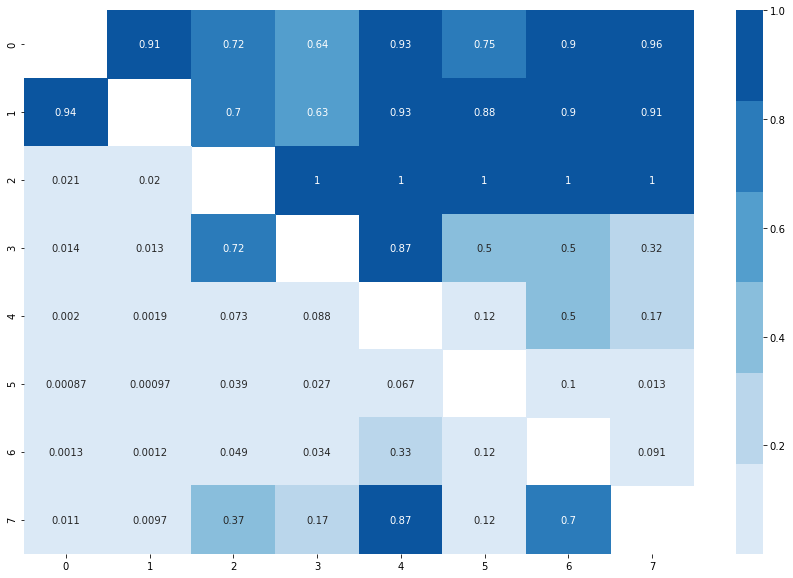

In [73]:
import seaborn as sns
conditional_heatplot(df_train, ['q_viirs', 'q_viirs_10', 'q_flag', 'q_flag_1', 'q_flag_2', 'q_flag_3', 'q_flag_4', 'q_flag_5']);

#### Naive classifier

In [74]:
fit_scores(y_true=df_train.q_viirs.values, y_fit=df_train.q_flag.values)

{'accuracy': 0.6200555555555556,
 'f1': 0.04175423847554995,
 'recall': 0.02149761939114125}

In [75]:
fit_scores(y_true=df_val.q_viirs.values, y_fit=df_val.q_flag.values)

{'accuracy': 0.6863333333333334, 'f1': 0.0, 'recall': 0.0}

In [76]:
fit_scores(y_true=df_train[df_train.delta_assim < 5].q_viirs.values, y_fit=df_train[df_train.delta_assim < 5].q_flag.values)

{'accuracy': 0.6191422891224084,
 'f1': 0.047923322683706075,
 'recall': 0.024630541871921183}

In [18]:
T = np.arange(1, dt + 1)
acc = []
f1  = []

for t in T:
    
    #fit = fit_scores(y_true=df_train[df_train.delta_assim < t].q_viirs.values, y_fit=df_train[df_train.delta_assim < t].q_flag.values)
    fit = fit_scores(y_true=df_val[df_val.delta_assim < t].q_viirs.values, y_fit=df_val[df_val.delta_assim < t].q_flag.values)

    acc.append(fit['accuracy'])
    f1.append(fit['f1'])
    

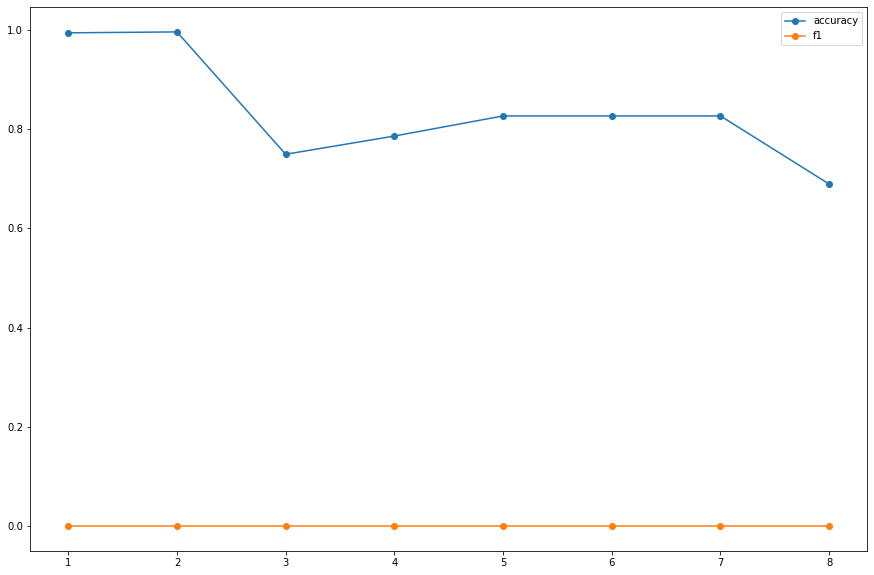

In [19]:
plt.plot(T, acc, 'o-', label = "accuracy")
plt.plot(T, f1, 'o-', label = "f1")
plt.legend()

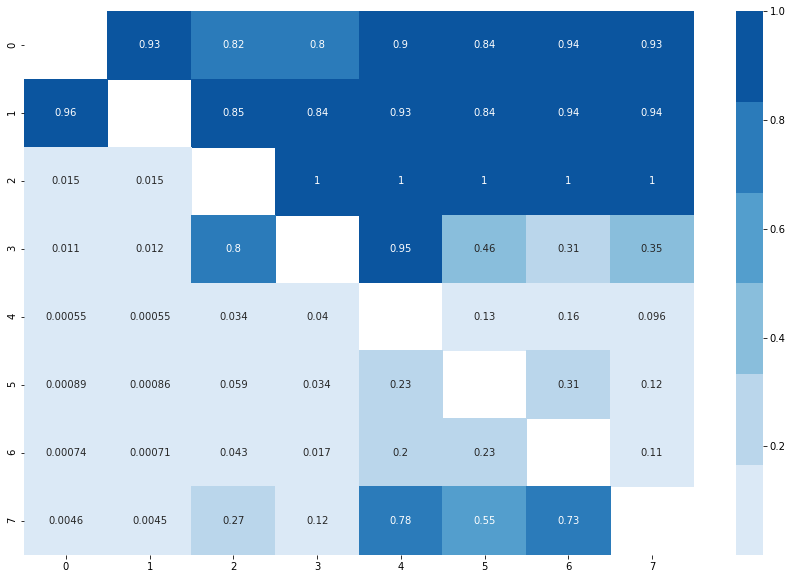

In [24]:
conditional_heatplot(df_train[df_train.delta_assim < 5], ['q_viirs', 'q_viirs_10', 'q_flag', 'q_flag_1', 'q_flag_2', 'q_flag_3', 'q_flag_4', 'q_flag_5']);

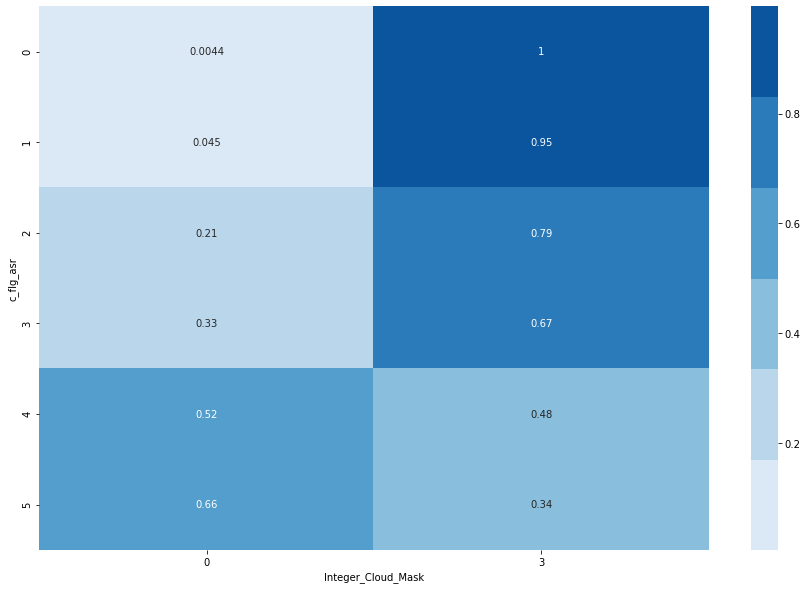

In [25]:
import seaborn as sns

ax = sns.heatmap(pd.crosstab(df_train_sample.c_flg_asr, df_train_sample.Integer_Cloud_Mask, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

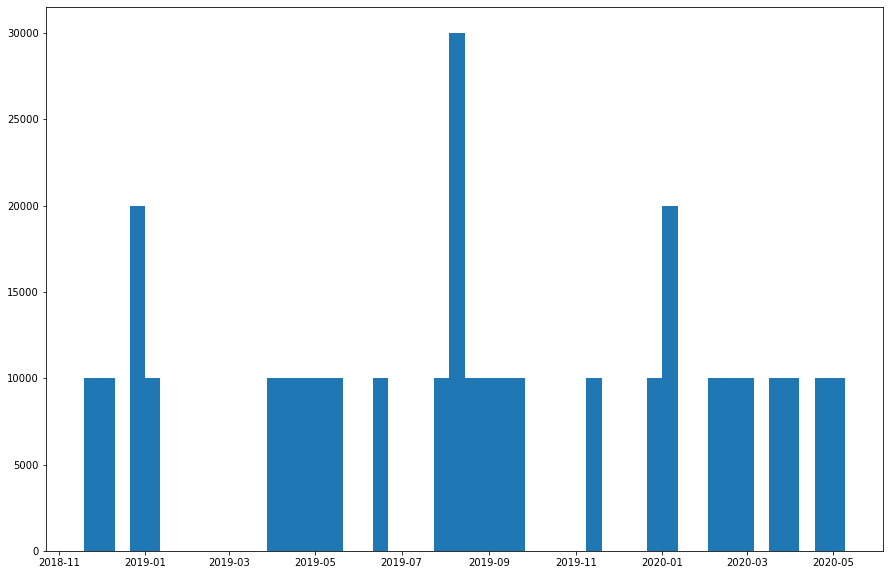

In [26]:
plt.hist(df_train.time.values,50);

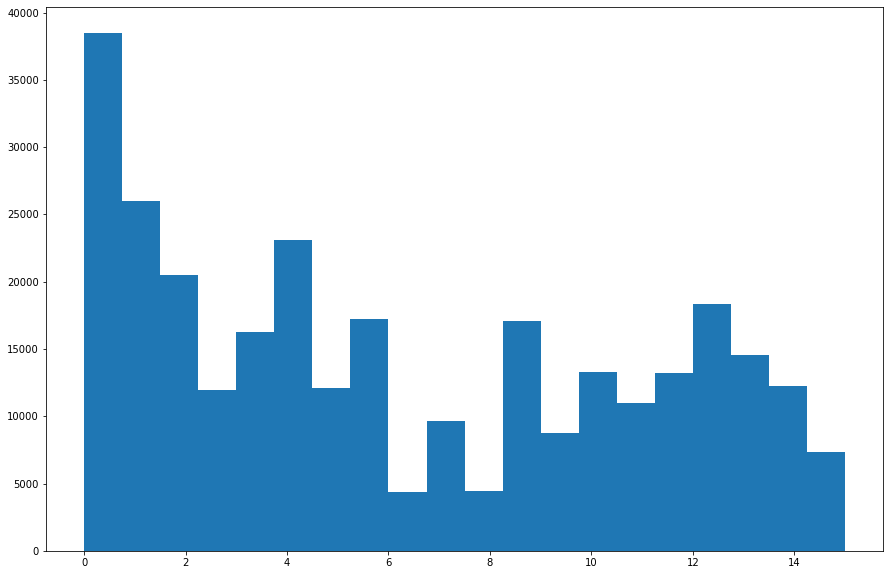

In [27]:
plt.hist(df_train.delta_assim.values, 20);

In [57]:
np.unique(df_train.q_viirs.values,  return_counts=True)

(array([0, 1]), array([385896, 294104]))

In [63]:
df_train[df_train.delta_assim < 5]

,ground_track,time,segment_id,beam_strength,lat,lon,height,slope_dx,slope_dy,snr,...,Integer_Cloud_Mask_k10,Integer_Cloud_Mask_k10_dist,delta_assim,q_flag_1,q_flag_2,q_flag_3,q_flag_4,q_flag_5,q_viirs,q_viirs_10
1,gt2r,2020-04-22 15:39:38.133368,394640,strong,70.903216,-45.316445,2509.491943,-0.001363,-4.660395e-03,51.062405,...,3,0.000370,3.635556,0,0,0,0,0,0,0
3,gt1l,2019-09-12 15:18:30.771039,599137,weak,72.329287,-48.184544,2444.672607,-0.002662,3.863595e-03,14.310707,...,3,0.000316,0.512851,0,0,0,0,0,0,0
4,gt1l,2019-09-12 15:18:32.188946,599640,weak,72.239909,-48.224734,2403.450439,-0.004390,4.412520e-03,10.688303,...,3,0.000320,0.536482,0,0,0,0,0,0,0
8,gt3r,2019-08-31 15:44:27.703120,619316,weak,68.746205,-47.400714,1651.120483,-0.004741,6.179084e-05,12.225956,...,3,0.000324,2.461719,0,0,0,0,0,0,0
14,gt2r,2019-09-12 15:18:26.168503,597388,strong,72.644087,-48.141152,2526.799316,0.004416,3.402823e+38,2.700489,...,0,0.000291,0.436142,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679957,gt3l,2019-09-12 15:18:32.906061,599906,weak,72.200378,-48.433550,2351.610596,-0.003373,4.273006e-04,18.642754,...,3,0.000340,0.548434,0,0,0,0,0,0,0
679958,gt2r,2020-04-22 15:39:49.126580,398540,strong,71.596887,-45.597095,2614.750977,-0.000507,-3.189600e-03,56.058338,...,3,0.000370,3.818776,0,0,0,0,0,0,0
679969,gt1r,2020-05-04 15:15:00.336189,402872,strong,72.362686,-48.359873,2427.986572,-0.006153,3.402823e+38,2.294168,...,3,0.000339,3.005603,0,0,0,0,0,0,0
679986,gt3r,2019-08-31 15:44:06.963021,611958,weak,70.056629,-46.949249,2025.080933,-0.004956,-5.768909e-04,13.337679,...,3,0.000324,2.116050,0,0,0,0,0,0,0


## Classification

In [35]:
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Decision Tree

- Is there something similar but more suitable for this problem? (SAT problem)

In [22]:
X_train.shape

(5000, 12)

In [117]:
Y_train.shape

(5000,)

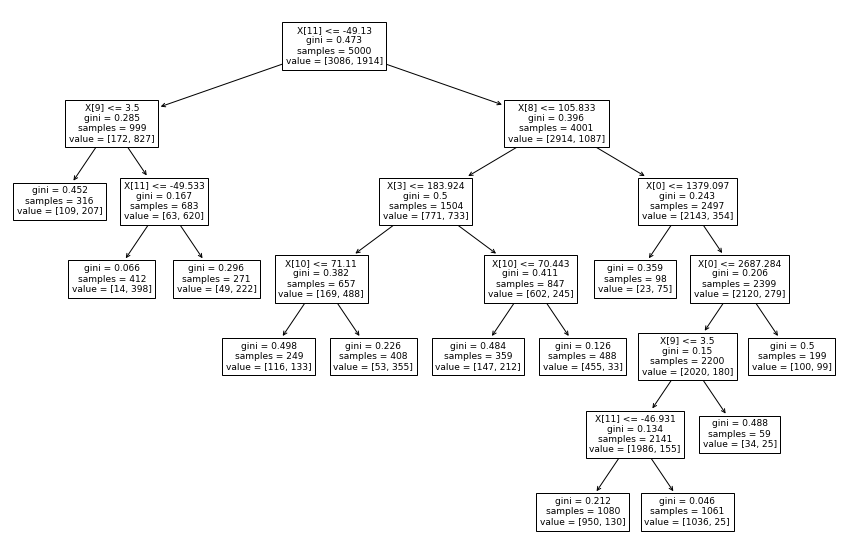

In [118]:
clf_tree = tree.DecisionTreeClassifier( max_depth=6, 
                                        min_samples_split = 500 )
clf_tree = clf_tree.fit(X_train, Y_train)
#clf_tree = clf_tree.fit(X_train, Y_train_fake)

tree.plot_tree(clf_tree);

In [119]:
Y_train_fit = clf_tree.predict(X_train)
Y_val_fit = clf_tree.predict(X_val)

In [120]:
fit_scores(Y_train, Y_train_fit)
#fit_scores(Y_train_fake, Y_train_fit)

{'accuracy': 0.8354, 'f1': 0.7956295008691334, 'recall': 0.8369905956112853}

In [121]:
fit_scores(Y_val, Y_val_fit)

{'accuracy': 0.497, 'f1': 0.14947582008792692, 'recall': 0.14267269205939315}

### Linear Discriminator Analysis (LDA)

For the simplest case where there are just two classes (cloud vs clear) and they have the same number of members, LDA coincides with a linear regression classifier based on that try to fit a one-hot vector based on the features.

In [123]:
clf_lda = LDA(store_covariance=True, shrinkage=None, solver='eigen')

In [124]:
clf_lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)

In [125]:
Y_train_fit = clf_lda.predict(X_train)
Y_val_fit = clf_lda.predict(X_val)

In [126]:
fit_scores(Y_train, Y_train_fit)

{'accuracy': 0.785, 'f1': 0.7029566178502349, 'recall': 0.664576802507837}

In [127]:
fit_scores(Y_val, Y_val_fit)

{'accuracy': 0.6154, 'f1': 0.30901904419690984, 'recall': 0.2775984506132989}

### Quadratic Discriminant Analysis

In [44]:
clf_qda = QuadraticDiscriminantAnalysis()

In [45]:
clf_qda.fit(X_train, Y_train)

/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [46]:
Y_train_fit = clf_qda.predict(X_train)
Y_val_fit = clf_qda.predict(X_val)

/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:743: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in

In [47]:
fit_scores(Y_train, Y_train_fit)

{'accuracy': 0.6188, 'f1': 0.0, 'recall': 0.0}

### Logistic Regression

In [159]:
clf_log = LogisticRegression(random_state=0, max_iter=10000000, penalty='l1', solver="liblinear", C = .02)
#clf_log = LogisticRegression(random_state=0, max_iter=10000000, penalty='none')

In [160]:
clf_log.fit(X_train_scaled, Y_train)

LogisticRegression(C=0.02, max_iter=10000000, penalty='l1', random_state=0,
                   solver='liblinear')

In [161]:
Y_train_fit = clf_log.predict(X_train_scaled)
Y_val_fit = clf_log.predict(X_val_scaled)

In [162]:
fit_scores(Y_train, Y_train_fit)

{'accuracy': 0.7806, 'f1': 0.7042329468859531, 'recall': 0.6823406478578893}

In [163]:
col_names

['height',
 'slope_dx',
 'slope_dy',
 'snr',
 'h_rb',
 'height_sigma',
 'snr_significance',
 's_fg',
 'n_fit_photons_ratio_w',
 'c_flg_asr',
 'lat',
 'lon']

In [164]:
clf_log.coef_

array([[-0.97663498,  0.01212373,  0.        ,  0.        , -0.08917724,
         0.03358932,  0.        ,  0.        , -0.34342594,  0.91985341,
         0.41230696,  0.        ]])

In [96]:
col_names

['height',
 'slope_dx',
 'slope_dy',
 'snr',
 'h_rb',
 'height_sigma',
 'snr_significance',
 's_fg',
 'n_fit_photons_ratio_w',
 'c_flg_asr']

In [53]:
fit_scores(Y_val, Y_val_fit)

{'accuracy': 0.6334, 'f1': 0.42629107981220654, 'recall': 0.44163424124513617}

### Support Vector Machine

In [47]:
clf_svm = svm.SVC()

In [48]:
clf_svm.fit(X_train_scaled, Y_train)

SVC()

In [49]:
Y_train_fit = clf_svm.predict(X_train_scaled)

In [50]:
fit_scores(Y_train, Y_train_fit)

{'accuracy': 0.8776, 'f1': 0.8394543546694648, 'recall': 0.8385744234800838}

### Random Forest

In [73]:
clf_rf = RandomForestClassifier(max_depth=4, random_state=0)
clf_rf.fit(X_train, Y_train)
Y_train_fit = clf_rf.predict(X_train)
Y_val_fit = clf_rf.predict(X_val)

In [74]:
fit_scores(Y_train, Y_train_fit)

{'accuracy': 0.8486, 'f1': 0.7847597384134204, 'recall': 0.7232704402515723}

In [75]:
fit_scores(Y_val, Y_val_fit)

{'accuracy': 0.5368,
 'f1': 0.011945392491467576,
 'recall': 0.009114583333333334}

### Bagging

In [56]:
clf = BaggingClassifier(base_estimator=LogisticRegression(max_iter=100000),
                        n_estimators=10, random_state=0).fit(X_train, Y_train)

#clf = BaggingClassifier(base_estimator=svm.SVC(),
#                        n_estimators=10, random_state=0).fit(X_train, Y_train)

In [57]:
Y_train_fit = clf.predict(X_train)

In [58]:
fit_scores(Y_train, Y_train_fit)

{'accuracy': 0.6658, 'f1': 0.2775616083009079, 'recall': 0.16823899371069181}

### PCA

In [25]:
pca = PCA(n_components=2)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

In [26]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = Y_train_color, s = 10)

NameError: name 'Y_train_color' is not defined

### t-SNE

In [31]:
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X_train_scaled)

In [32]:
nice_red = "#8e44ad"
nice_blue = "#3498db"
Y_train_color = [nice_red if x == 1 else nice_blue for x in Y_train]

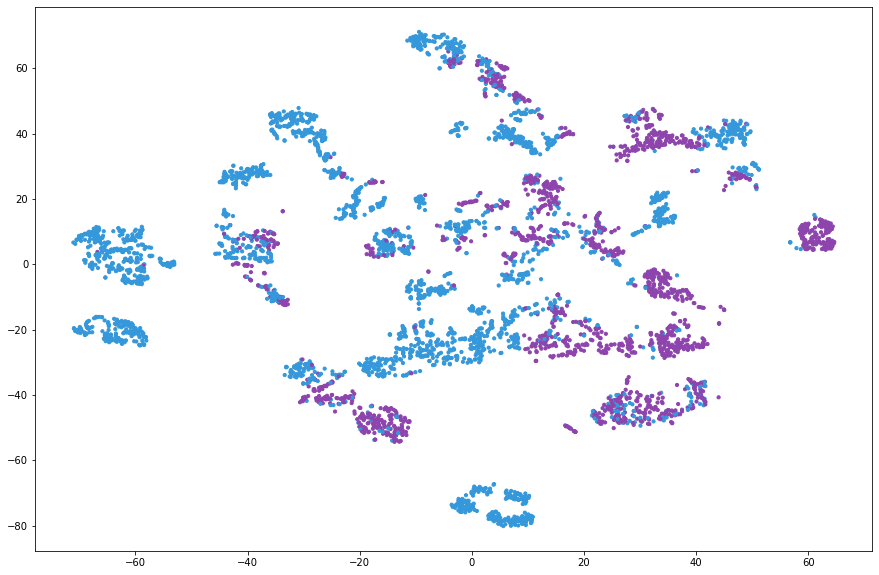

In [33]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = Y_train_color, s = 10)

### Model comparison

In [78]:
models = [tree.DecisionTreeClassifier( max_depth=2, min_samples_split = 500 ),
          tree.DecisionTreeClassifier( max_depth=3, min_samples_split = 500 ),
          tree.DecisionTreeClassifier( max_depth=4, min_samples_split = 500 ),
          tree.DecisionTreeClassifier( max_depth=5, min_samples_split = 500 ),
          LDA(store_covariance=True, shrinkage=None, solver='eigen'),
          QuadraticDiscriminantAnalysis(),
          BaggingClassifier(n_estimators=10, random_state=0)
          ]

In [79]:
for clf in models:
    print(clf)
    clf.fit(X_train, Y_train)
    Y_train_fit = clf.predict(X_train)
    Y_val_fit = clf.predict(X_val)
    print("Training:", fit_scores(Y_train, Y_train_fit))
    print("Validati:", fit_scores(Y_val, Y_val_fit))
    print("")

DecisionTreeClassifier(max_depth=2, min_samples_split=500)
Training: {'accuracy': 0.746, 'f1': 0.5871261378413524, 'recall': 0.47327044025157233}
Validati: {'accuracy': 0.6928, 'f1': 0.0, 'recall': 0.0}

DecisionTreeClassifier(max_depth=3, min_samples_split=500)
Training: {'accuracy': 0.8038, 'f1': 0.7556662515566626, 'recall': 0.7950733752620545}
Validati: {'accuracy': 0.5336, 'f1': 0.020168067226890754, 'recall': 0.015625}

DecisionTreeClassifier(max_depth=4, min_samples_split=500)
Training: {'accuracy': 0.8466, 'f1': 0.8032828930494998, 'recall': 0.8207547169811321}
Validati: {'accuracy': 0.526, 'f1': 0.2950624628197502, 'recall': 0.3229166666666667}

DecisionTreeClassifier(max_depth=5, min_samples_split=500)
Training: {'accuracy': 0.8616, 'f1': 0.8314661471018023, 'recall': 0.8946540880503144}
Validati: {'accuracy': 0.5166, 'f1': 0.29099442651804047, 'recall': 0.3229166666666667}

LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
Training: {'accuracy': 0.7798, 'f1':

/glade/u/home/fsapienza/.conda/envs/cloudmaskenv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Training: {'accuracy': 0.6946, 'f1': 0.3938070662961493, 'recall': 0.259958071278826}
Validati: {'accuracy': 0.6656, 'f1': 0.046750285062713795, 'recall': 0.026692708333333332}

BaggingClassifier(random_state=0)
Training: {'accuracy': 0.9958, 'f1': 0.9944780436497502, 'recall': 0.9910901467505241}
Validati: {'accuracy': 0.425, 'f1': 0.08410321758521823, 'recall': 0.0859375}



In [76]:
models = [LogisticRegression(random_state=0, max_iter=10000000, penalty='none'),
          LogisticRegression(random_state=0, max_iter=10000000, penalty='none', solver='newton-cg'),
          LogisticRegression(random_state=0, max_iter=10000000, penalty='l1', solver="liblinear", C = 1),
          LogisticRegression(random_state=0, max_iter=10000000, penalty='l1', solver="liblinear", C = .01), 
          LogisticRegression(random_state=0, max_iter=10000000, penalty='l1', solver="liblinear", C = .0001),
          BaggingClassifier(base_estimator=LogisticRegression(random_state=0, max_iter=10000000, penalty='l1', solver="liblinear", C = .01), n_estimators=10, random_state=0),
          svm.SVC(),
          BaggingClassifier(base_estimator=svm.SVC(), n_estimators=10, random_state=0)
         ]

In [77]:
for clf in models:
    print(clf)
    clf.fit(X_train_scaled, Y_train)
    Y_train_fit = clf.predict(X_train_scaled)
    Y_val_fit = clf.predict(X_val_scaled)
    print("Training:", fit_scores(Y_train, Y_train_fit))
    print("Validati:", fit_scores(Y_val, Y_val_fit))
    #print(clf.coef_)
    print("")

LogisticRegression(max_iter=10000000, penalty='none', random_state=0)
Training: {'accuracy': 0.7906, 'f1': 0.71307207454097, 'recall': 0.6818658280922432}
Validati: {'accuracy': 0.516, 'f1': 0.27588270496708556, 'recall': 0.3001302083333333}

LogisticRegression(max_iter=10000000, penalty='none', random_state=0,
                   solver='newton-cg')
Training: {'accuracy': 0.7906, 'f1': 0.71307207454097, 'recall': 0.6818658280922432}
Validati: {'accuracy': 0.516, 'f1': 0.27588270496708556, 'recall': 0.3001302083333333}

LogisticRegression(C=1, max_iter=10000000, penalty='l1', random_state=0,
                   solver='liblinear')
Training: {'accuracy': 0.791, 'f1': 0.7133058984910836, 'recall': 0.6813417190775681}
Validati: {'accuracy': 0.5238, 'f1': 0.2729770992366412, 'recall': 0.291015625}

LogisticRegression(C=0.01, max_iter=10000000, penalty='l1', random_state=0,
                   solver='liblinear')
Training: {'accuracy': 0.7674, 'f1': 0.6884543262791322, 'recall': 0.673480083857

### EDA perfect match

In [13]:
pd.crosstab(df.q_flag,df.Integer_Cloud_Mask_k1)

Integer_Cloud_Mask_k1,-1,0,1,2,3
q_flag,,,,,
0,49,791463,170704,30366,2440704
1,0,147403,15196,2837,68231


We can see some correlation between ATL06 flag (q_flag = 1) and cloud in VIIRS (Integer_Cloud_Mask = 0)

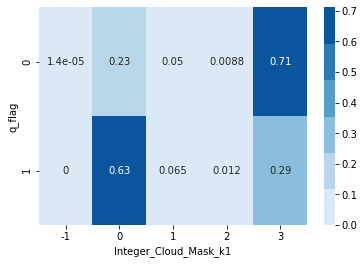

In [14]:
import seaborn as sns

ax = sns.heatmap(pd.crosstab(df.q_flag,df.Integer_Cloud_Mask_k1, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

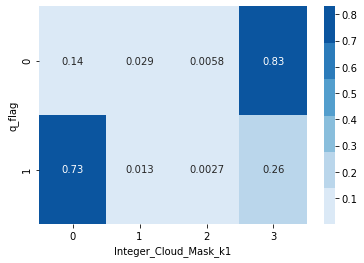

In [24]:
df2 = df[ df.delta_assim < 5 ]

ax = sns.heatmap(pd.crosstab(df2.q_flag,df2.Integer_Cloud_Mask_k1, normalize = "index"), annot=True, cmap = sns.color_palette("Blues"))

### Functions I didn't use

In [10]:
# Do we use this function?
def orbit_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


def print_attrs(name, obj):
    '''
    Retrieves all attributes from hd5 file
    Use: f.visititems(print_attrs)
    '''
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

In [13]:
f_.visititemns(print_attrs)

AttributeError: 'File' object has no attribute 'visititemns'

In [22]:
f_['QA_dimension'][:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [32]:
def print_attrs_h5(h5file, counter = 0):
    '''
    Print all the atrivbutes from a h5 file
    '''
    for key in h5file.keys():
        
        try:
            print_attrs_h5(h5file[key], counter + 1)
            
        except:
            print('\t'*counter, end = '')
            print(key)

In [33]:
print_attrs_h5(f_)

QA_dimension
byte_segment
	latitude
	longitude
	sensor_azimuth
	sensor_zenith
	solar_azimuth
	solar_zenith
	Clear_Sky_Confidence
	Cloud_Mask
	Integer_Cloud_Mask
	Quality_Assurance
number_of_lines
number_of_pixels
number_of_scans
	scan_start_time


In [25]:
print('\t hola')

	 hola
